In [18]:
#export

import numpy as np
import matplotlib.pyplot as plt
import math

class model():
    def __init__(self, X_dataset,Y_dataset, learning_rate = 0.1):
        self.X = X_dataset
        self.Y = Y_dataset
        self.W1 = np.random.rand(10, 784) -.5
        self.b1 = np.random.rand(10,1) -.5
        self.W2 = np.random.rand(10,10) -.5
        self.b2 = np.random.rand(10,1) -.5
        self.learning_rate = learning_rate
    
    def update(self,X_dataset, Y_dataset):
        self.X = X_dataset
        self.Y = Y_dataset

    def get_predictions(self,Y_hat):
        predictions = np.argmax(Y_hat,0)
        return predictions

    
    def accuracy(self, Y_hat, Y):
        
        predictions = self.get_predictions(Y_hat)
        return np.sum(predictions == Y) / Y.size
    
    def gradient_descent(self, iterations, learning_rate=0.5):

        m = self.X.shape[1]
        one_hot_Y = self.one_hot_encode(self.Y)
        for iteration in range(iterations):

            Z1, A1, Z2, Y_hat = self.forward_pass(X=self.X)

            DW1, Db1, DW2, Db2 = self.backwards_propagation(Y_hat,one_hot_Y, self.X,Z2, A1, Z1, m)
            self.update_params( DW1, Db1, DW2, Db2, self.learning_rate)

            accuracy = self.accuracy(Y_hat, self.Y)
            if iteration% 20 == 0:
                loss = self.cross_entropy_loss(one_hot_Y, Y_hat)
                print(f"Iteration={iteration} \n    {accuracy=}\n    {loss=}")

    
    def ReLU(self, n: float) -> float:
        """rectified linear unit activation function"""
        return np.maximum(n, 0)

    def ReLU_deriv(self, n: float) -> int:
        """"derivative of ReLU"""
        return n > 0

    def softmax(self, array: np.array) -> np.array:
        # collapses 1 dimension of array
        # np.exp(s) / sum(np.exp(s))
        return np.exp(array) / np.sum(np.exp(array), axis=0)

    def forward_pass(self, X):
        Z1 = np.dot(self.W1, X) + self.b1
        A1 = self.ReLU(Z1)
        Z2 = self.W2.dot(A1) + self.b2
        Y_hat = self.softmax(Z2) 
        return Z1, A1, Z2, Y_hat

    def one_hot_encode(self, Y: np.array, classes = 10):
        # first instantiate 0's which should be an array of len(Y) max(Y) 
        one_hot = np.zeros((Y.size,classes))
        one_hot[np.arange(Y.size), Y] = 1
        return one_hot.T

    def cross_entropy_loss(self, y_actual, y_predictions):
        num_samples=len(y_actual)
        class_targets =np.array(y_actual)
        y_actual = y_actual
        y_pred_clipped = np.clip(y_predictions, 1e-7, 1-1e-7)
        if len(y_actual.shape) ==1:
            targeted_predictions = y_pred_clipped[[range(num_samples), class_targets]]
        elif len(y_actual.shape) == 2:
            targeted_predictions = np.sum(y_pred_clipped.T * y_actual.T, axis=1)
        negative_log_likelihoods = -np.log(targeted_predictions)
        return np.mean(negative_log_likelihoods)
    

    def backwards_propagation(self, Y_hat, Y, X, Z2, A1, Z1, m):
        DZ2 =  -Y +Y_hat 
        DW2 = np.dot(DZ2,A1.T) / m
        
        Db2 = np.sum(DZ2) / m

        DZ1 = np.dot(self.W2.T, DZ2) * self.ReLU_deriv(Z1)

        DW1 = np.dot(DZ1, self.X.T) / m
        Db1 =  np.sum(DZ1) / m
        return DW1, Db1, DW2, Db2


    def update_params(self, dW1, db1, dW2, db2, learning_rate):
        self.W1 = self.W1 - learning_rate*dW1
        self.b1 = self.b1 - learning_rate*db1
        self.W2 = self.W2 - learning_rate*dW2
        self.b2 = self.b2 - learning_rate*db2


    def make_prediction(self,X):
        print(X.shape)
        _,_,_, Y_hat = self.forward_pass(X)
        predictions = self.get_predictions(Y_hat)
        return predictions

    def test_predict(self,sample_index):
        current_image = self.X[:, sample_index, None]
        sample = self.Y[sample_index]
        current_image = current_image.reshape((28,28))*255

        plt.gray()
        plt.imshow(current_image, interpolation="nearest")
        plt.show()
        sample = self.Y[sample_index]
        X_sample = self.X[sample_index]
        prediction = self.make_prediction(self.X[:,sample_index, None])
        print(f"{sample=} , prediction = {prediction}. Correct = {sample == prediction[0]}")

    def export_weights(self):
        return self.W1, self.b1, self.W2, self.b2
    
    def import_weights(self, W1, b1, W2, b2):
        self.W1 = W1
        self.b1 = b1
        self.W2 = W2
        self.b2 = b2


            


In [46]:
import get_data
X_train, Y_train, X_test, Y_test = get_data.import_mnist()

# normalize pixel data to values between 0 and 1. Max = 255, min = 0, thus divide by 255
X_train = X_train / 255.0
X_test = X_test / 255.0

In [26]:

mod = model(X_train, Y_train, learning_rate=0.5)


In [27]:

mod.gradient_descent(300)
saved_W1, saved_b1 , saved_W2 ,saved_b2  = mod.export_weights()



Iteration=0 
    accuracy=0.09656827613793563
    loss=3.6940192112285306
Iteration=20 
    accuracy=0.5074917915298588
    loss=1.393161981457739
Iteration=40 
    accuracy=0.6094268237803964
    loss=1.0760056178116313
Iteration=60 
    accuracy=0.6862781046350772
    loss=0.906381656790393
Iteration=80 
    accuracy=0.7305621760362673
    loss=0.7898994228330328
Iteration=100 
    accuracy=0.7771462857714295
    loss=0.6751557827097653
Iteration=120 
    accuracy=0.7960132668877815
    loss=0.619509473134814
Iteration=140 
    accuracy=0.8149469157819297
    loss=0.577037098090081
Iteration=160 
    accuracy=0.8290638177302955
    loss=0.5443400949019157
Iteration=180 
    accuracy=0.8407973466224437
    loss=0.5168395081218579
Iteration=200 
    accuracy=0.8507808463474391
    loss=0.4915025952735083
Iteration=220 
    accuracy=0.8577142952382539
    loss=0.47011426952933283
Iteration=240 
    accuracy=0.8638977316288605
    loss=0.4527289373367089
Iteration=260 
    accuracy=0.869

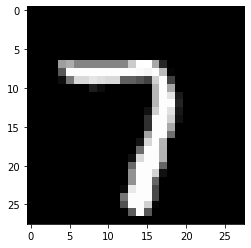

(784, 1)
sample=7 , prediction = [7]. Correct = True


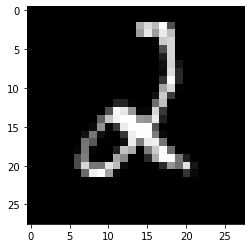

(784, 1)
sample=2 , prediction = [6]. Correct = False


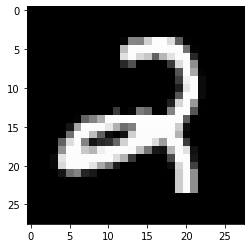

(784, 1)
sample=2 , prediction = [2]. Correct = True


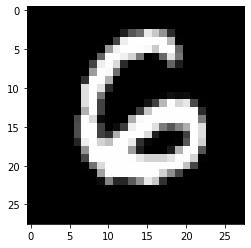

(784, 1)
sample=6 , prediction = [6]. Correct = True


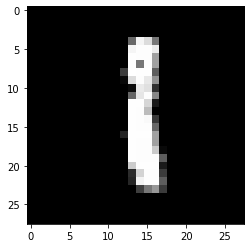

(784, 1)
sample=1 , prediction = [1]. Correct = True


In [28]:
for i in range(5):
    mod.test_predict(i)


In [35]:


!./notebook2script.py nn_model.ipynb



Converted nn_model.ipynb to exp/nb_nn.py
